## Part-of-Speech tagging (POS)

O Part-of-Speech ou Partes-de-fala em tradução livre para o português, identifica as possíveis classes gramaticais de uma sentença. Em nosso exemplo utilizaremos a biblioteca Spacy para uma aplicação rápida.

In [1]:
# Importando Spacy e sua biblioteca em português
import re
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import numpy as np
import pandas as pd
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
import string
import pt_core_news_lg
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Importando Word2Vec da biblioteca gensim
from gensim.models import Word2Vec

plt.style.use('ggplot')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [2]:
df_classif_erika_modelo_pos_ajuste = pd.read_csv('data/tweets_erika_modelo_ajustado.csv')

In [3]:
df_tweets_neg = df_classif_erika_modelo_pos_ajuste[df_classif_erika_modelo_pos_ajuste['classe_ajuste_fino'] == True]

,count,mean,std,min,25%,50%,75%,max
score_ajuste_fino,2441.0,0.876816,0.136975,0.501753,0.802326,0.939163,0.986528,0.998632


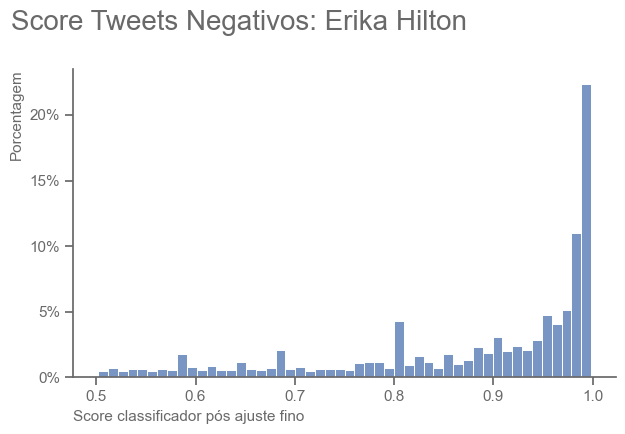

In [4]:
plt.figure(figsize=(7,4))
ax = sns.histplot(df_tweets_neg, x = 'score_ajuste_fino', stat = 'percent', bins = 50)
ax.set_title('Score Tweets Negativos: Erika Hilton', fontsize=20, x=0.306, y=1.1, color="#696969")
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("Porcentagem", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("Score classificador pós ajuste fino", fontsize=11, loc="left", color="#696969")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(decimals=0))

df_tweets_neg['score_ajuste_fino'].describe().to_frame().T

In [5]:
# Instanciando Spacy
nlp = spacy.load("pt_core_news_lg")

In [15]:
# Definindo documento
# doc = nlp('Eu queria saber onde você aprendeu sobre NLP, Pedro!')

In [16]:
# Aplicando POS tag com spacy
# [(token.orth_, token.tag_) for token in doc]

### Legenda das tags:

* ADJ: adjetivo
* ADP: adposição
* ADV: advérbio
* AUX: auxiliar
* CONJ: conjunção
* CCONJ: conjunção coordenativa
* DET:  determinante
* INTJ: interjeição
* NOUN: substantivo
* NUM:  numeral
* PRON: pronome
* PROPN: nome próprio
* PUNCT: pontuação
* SCONJ: Conjunção subordinada
* SYM: símbolo
* VERB: verbo
* X: outro

# Named Entity Recognition (NER)

O Named Entity Recognition ou Reconhecimento da Entidade Nomeada na tradução livre para o português, identifica as entidades presentes dentro de um documento, além de ser capaz de classifica-las a partir de categorias pré definidas como local, pessoa, organização, etc.

In [ ]:
# Definindo documento
# doc = nlp('Machado de Assis um dos melhores escritores do Brasil, foi o primeiro presidente da Academia Brasileira de Letras')

In [17]:
# Visualizando entidades com spacy
# doc.ents

In [18]:
# Visualizando detalhe das entidades com spacy
# [(entidade, entidade.label_) for entidade in doc.ents]

# Word Embeddings

As técnicas do Bag of Words e TF-IDF combinadas com uma boa limpeza de stop words, stemming e lemmatization geralmente geram resultados relevantes em nossas modelagens, mas e se quiséssemos ir um passo além? E se ao invés de contarmos frequências e ocorrências de palavras passássemos a buscar por contextos, informações semânticas e sintáticas nos textos? 

Fazer isso seria quase como ensinar uma máquina a realmente ler e compreender textos, como um humano faz. Para entender melhor sobre isso iremos entrar no mundo das redes neurais e dos word emebeddings! 

Algoritmos de Machine Learning e DeepLearning são especialistas em encontrar padrões em espaços N dimensionais e realizar operações matemáticas com matrizes e vetores. E se houvesse uma forma de transformarmos uma palavra em um vetor? Será que nossa máquina entenderia melhor seu significado?

In [7]:
# Selecionando pontuação e stopwords para limpeza
punct = ['.',',','!','?',':',';',')','(', '@']                               # Definindo lista de pontuações
stopwords_portugues = nltk.corpus.stopwords.words('portuguese') # Definindo lista de stopwords                                           # Adiciona tokens a lista 

In [8]:
tokens_todos_tweets = [] # Cria lista para armazenar tokens de todos os tweets                                                
for doc in df_classif_erika_modelo_pos_ajuste['tweets']:
    token = (word_tokenize(doc))
    token_lwr = [x.lower() for x in token]                             # Tudo para minúsculo
    token_stp = [x for x in token_lwr if x not in stopwords_portugues] # Remove Stopwords
    token_pct = [x for x in token_stp if x not in punct]               # Remove pontuações
    tokens_todos_tweets.append(token_pct)

In [9]:
# Cria coluna com tokens sem stopwords no dataframe
df_classif_erika_modelo_pos_ajuste['tokens_limpos'] = tokens_todos_tweets

In [10]:
tokens_tweets_neg = [] # Cria lista para armazenar tokens de todos os tweets                                                
for doc in df_tweets_neg['tweets']:
    token = (word_tokenize(doc))
    token_lwr = [x.lower() for x in token]                             # Tudo para minúsculo
    token_stp = [x for x in token_lwr if x not in stopwords_portugues] # Remove Stopwords
    token_pct = [x for x in token_stp if x not in punct]               # Remove pontuações
    tokens_tweets_neg.append(token_pct)

In [11]:
# Cria coluna com tokens sem stopwords no dataframe
df_tweets_neg['tokens_limpos'] = tokens_tweets_neg

C:\Users\55199\AppData\Local\Temp\ipykernel_884\3291442508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_neg['tokens_limpos'] = tokens_tweets_neg


In [8]:
#Visualizando nova coluna tokens_clean
df_classif_erika_modelo_pos_ajuste.head()

,tweets,classe_ajuste_fino,score_ajuste_fino,tokens_limpos
0,"Ao longo do dia estou recebendo denúncias, inc...",False,0.988363,"[longo, dia, recebendo, denúncias, inclusive, ..."
1,@ErikakHilton Simplesmente a maior ❤️❤️❤️ http...,False,0.997873,"[erikakhilton, simplesmente, maior, ❤️❤️❤️, ht..."
2,@PalasAthenas18 Hahahhaha 💜💜💜,False,0.955207,"[palasathenas18, hahahhaha, 💜💜💜]"
3,"Ao longo do dia estou recebendo denúncias, inc...",False,0.988363,"[longo, dia, recebendo, denúncias, inclusive, ..."
4,@ErikakHilton É isso aí...,False,0.964833,"[erikakhilton, aí, ...]"


In [12]:
df_tweets_neg.head()

,tweets,classe_ajuste_fino,score_ajuste_fino,tokens_limpos
17,@ErikakHilton É de uma vergonha sem tamanho......,True,0.928661,"[erikakhilton, vergonha, tamanho, ..., prf, tá..."
29,@ErikakHilton Criancinhas birrentas kkk,True,0.995792,"[erikakhilton, criancinhas, birrentas, kkk]"
58,"@ErikakHilton Gatan, toca esses véio de Guarul...",True,0.994986,"[erikakhilton, gatan, toca, véio, guarulhos, q..."
64,@ErikakHilton Pega eles mami,True,0.950024,"[erikakhilton, pega, mami]"
73,"@ErikakHilton MINHA DEPUTADA, CARAAALHO. 😍😍😍😍",True,0.820700,"[erikakhilton, deputada, caraaalho, 😍😍😍😍]"


In [13]:
def join_tokens_as_text(tokens_list):
    return ' '.join(tokens_list)

In [14]:
df_classif_erika_modelo_pos_ajuste['tokens_texto'] = df_classif_erika_modelo_pos_ajuste['tokens_limpos'].apply(join_tokens_as_text)

In [15]:
tweets_negativos = df_classif_erika_modelo_pos_ajuste[df_classif_erika_modelo_pos_ajuste['classe_ajuste_fino'] == True]

In [16]:
tweets_negativos.sample(20)

,tweets,classe_ajuste_fino,score_ajuste_fino,tokens_limpos,tokens_texto
10631,@ErikakHilton Opa... O Leão do imposto de rend...,True,0.793884,"[erikakhilton, opa, ..., leão, imposto, renda,...",erikakhilton opa ... leão imposto renda vai vi...
11440,@ErikakHilton BOLSONARO NÃO MEXA NO MEU SALÁRI...,True,0.984876,"[erikakhilton, bolsonaro, mexa, salário, bolso...",erikakhilton bolsonaro mexa salário bolsonaro ...
10612,@ErikakHilton @philosopop SONEGADORES COM BOLS...,True,0.962982,"[erikakhilton, philosopop, sonegadores, bolson...",erikakhilton philosopop sonegadores bolsonaro ...
17596,@ErikakHilton TRADUÇÃO: intelectual gostosa é ...,True,0.854975,"[erikakhilton, tradução, intelectual, gostosa,...",erikakhilton tradução intelectual gostosa elei...
5358,@ErikakHilton SÃO PAULO NÃO VOTA EM ASSASSINO!...,True,0.960666,"[erikakhilton, paulo, vota, assassino, https, ...",erikakhilton paulo vota assassino https //t.co...
10786,@ErikakHilton só a turminha do bem nessa LIVE ...,True,0.994233,"[erikakhilton, turminha, bem, nessa, live, son...",erikakhilton turminha bem nessa live sonegação...
11081,@ErikakHilton Meu voto dia 30 não será só por ...,True,0.835606,"[erikakhilton, voto, dia, 30, mim, filhas, tod...",erikakhilton voto dia 30 mim filhas todos excr...
11483,@ErikakHilton BOLSONARO NÃO MEXA NO MEU SALÁRI...,True,0.984577,"[erikakhilton, bolsonaro, mexa, salário, bolso...",erikakhilton bolsonaro mexa salário bolsonaro ...
656,@ErikakHilton Tomar no cu,True,0.931034,"[erikakhilton, tomar, cu]",erikakhilton tomar cu
17098,@ErikakHilton Esqueceu que em 10 anos de convi...,True,0.570327,"[erikakhilton, esqueceu, 10, anos, convivência...",erikakhilton esqueceu 10 anos convivência chef...


In [17]:
#Instanciando Word2Vec para todos os tweets
w2v_model = Word2Vec(sentences = df_classif_erika_modelo_pos_ajuste['tokens_limpos'],   # Passando listas de tokens tratados
                     min_count=5,                                     # Mínimo de ocorrências para considerar a palavra
                     vector_size=400,                                 # Dimensão final do embedding 
                     window=5,                                        # Janela de contexto 
                     seed = 42                                        # Definindo fator Pseudo aleatório
                     )

In [18]:
#Visualizando os 20 primeiros valores do vetor da palavra "Lula" para todos os tweets
print(w2v_model.wv.get_vector('erikakhilton').shape)
w2v_model.wv.get_vector('erikakhilton')[:20]

(400,)


array([ 5.2681763e-02, -5.6873295e-03,  8.5086504e-05,  6.9323801e-02,
       -1.6341302e-01,  1.4438842e-01,  4.7380969e-02,  1.4886194e-01,
       -1.7972799e-01, -2.6780531e-01,  6.5407865e-02,  2.1176854e-01,
        9.4495863e-03,  3.6845580e-02, -3.3338666e-02,  1.2076117e-02,
        1.0287546e-01, -1.2470707e-01, -5.6791082e-03,  1.7411786e-01],
      dtype=float32)

In [19]:
#Instanciando Word2Vec para tweets negativos
w2v_model_neg = Word2Vec(sentences = tweets_negativos['tokens_limpos'],   # Passando listas de tokens tratados
                         min_count=5,                                     # Mínimo de ocorrências para considerar a palavra
                         vector_size=400,                                 # Dimensão final do embedding 
                         window=5,                                        # Janela de contexto 
                         seed = 42                                        # Definindo fator Pseudo aleatório
                        )

In [20]:
#Visualizando os 20 primeiros valores do vetor da palavra "Lula" para tweets negativos
print(w2v_model_neg.wv.get_vector('erikakhilton').shape)
w2v_model_neg.wv.get_vector('erikakhilton')[:20]

(400,)


array([-0.04737449,  0.06184265,  0.00418356,  0.03119004, -0.15333165,
        0.00157282, -0.0327277 , -0.05664161,  0.06710084, -0.18703686,
       -0.0859016 ,  0.02529011,  0.00743652,  0.16741426, -0.20068856,
       -0.20931153,  0.06214799, -0.01443122, -0.10172741,  0.11999505],
      dtype=float32)

# PCA

Com a aplicação de um PCA (Principal Component Analysis) podemos reduzir a quantidade de dimensões de 400 para 2, dessa forma, podemos visualizar as palavras dentro de um espaço vetorial! 

Embora a interpretabilidade do eixo X e Y seja quase zero, é um ótimo exercício para gerar insights e se divertir um pouco!

In [21]:
# Definindo palavras que serão visualizadas
palavras = ['lula','bolsonaro','vergonha','crime','mentira', 'democracia']

In [22]:
# Obtendo vetores das palavras
palavra_vec = []
for i in palavras:
    palavra_vec.append(w2v_model.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x = StandardScaler().fit_transform(palavra_vec)

# Instanciando PCA
pca = PCA(n_components=2)

# Fitando PCA
palavras_pca = pca.fit_transform(x)

Text(0.24, 1.12, '${Contexto\\ de\\ todos\\ os\\ Tweets\\ com\\ as\\ palavras\\ selecionadas}$')

<Figure size 800x500 with 0 Axes>

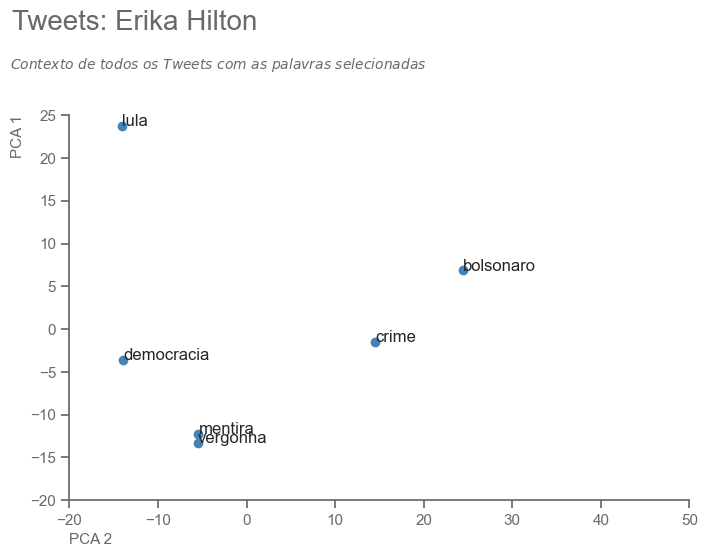

In [82]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets: Erika Hilton', fontsize=20, x=0.105, y=1.2, color="#696969")
ax.set_xlim(-20,50)
ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ de\ todos\ os\ Tweets\ com\ as\ palavras\ selecionadas}$"

# Add the subtitle with formatted text
ax.text(0.24, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

In [39]:
# Obtendo vetores das palavras
palavra_vec_neg = []
for i in palavras:
    palavra_vec_neg.append(w2v_model_neg.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x_neg = StandardScaler().fit_transform(palavra_vec_neg)

# Instanciando PCA
pca_neg = PCA(n_components=2)

# Fitando PCA
palavras_pca_neg = pca_neg.fit_transform(x_neg)

Text(0.255, 1.12, '${Contexto\\ dos\\ Tweets\\ Negativos\\ com\\ as\\ palavras\\ selecionadas}$')

<Figure size 800x500 with 0 Axes>

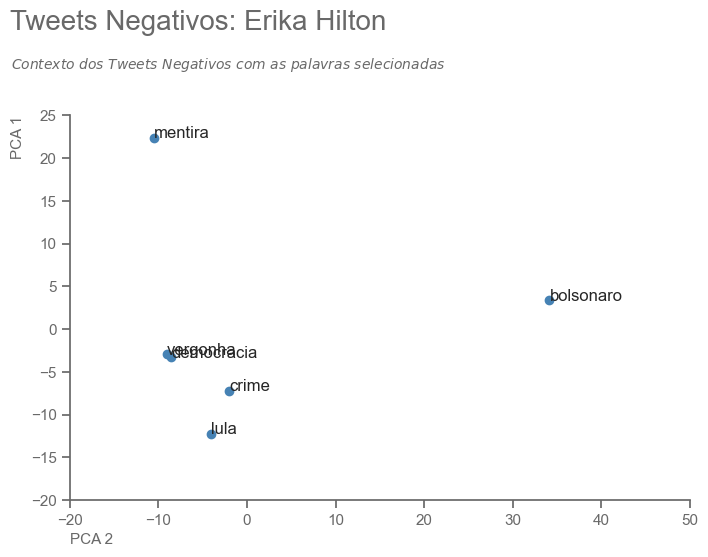

In [44]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca_neg:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets Negativos: Erika Hilton', fontsize=20, x=0.207, y=1.2, color="#696969")
ax.set_xlim(-20,50)
ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ dos\ Tweets\ Negativos\ com\ as\ palavras\ selecionadas}$"

# Add the subtitle with formatted text
ax.text(0.255, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

# Similaridade de vetores

In [45]:
# Visualizando vetores similares ao vetor "bolsonaro" modelo com todos os tweets
w2v_model.wv.most_similar('bolsonaro')

[('apoia', 0.986605167388916),
 ('peguem', 0.9863303303718567),
 ('crime', 0.9826913475990295),
 ('minimo', 0.9797568321228027),
 ('sonegadores', 0.9752995371818542),
 ('fuzilem', 0.9748788475990295),
 ('golpe', 0.9741823077201843),
 ('🚓', 0.9741811752319336),
 ('💸', 0.9707159399986267),
 ('mínimo', 0.9667864441871643)]

In [46]:
# Visualizando vetores similares ao vetor "bolsonaro" modelo com tweets negativos
w2v_model_neg.wv.most_similar('bolsonaro')

[('mentiu', 0.9895708560943604),
 ('mente', 0.9680036306381226),
 ('censurou', 0.9642642140388489),
 ('sonegadores', 0.9544533491134644),
 ('novamente', 0.9542151093482971),
 ('janones', 0.9520159959793091),
 ('mexa', 0.9043174386024475),
 ('salário', 0.8936980962753296),
 ('mg', 0.8237066268920898),
 ('sonegação', 0.7989763021469116)]

In [47]:
# Visualizando vetores similares ao vetor "lula" modelo com todos os tweets
w2v_model.wv.most_similar('lula')

[('amanhã', 0.9917696714401245),
 ('show', 0.9911112785339355),
 ('dl', 0.9897729158401489),
 ('luis', 0.9883682131767273),
 ('presidente', 0.9880068302154541),
 ('inácio', 0.9869748950004578),
 ('luís', 0.9860871434211731),
 ('luiz', 0.9860231280326843),
 ('silva', 0.9833531379699707),
 ('debate', 0.9785717725753784)]

In [48]:
# Visualizando vetores similares ao vetor "lula" modelo com tweets negativos
w2v_model_neg.wv.most_similar('lula')

[('criminoso', 0.988871157169342),
 ('venceu', 0.9843276143074036),
 ('debate', 0.9813660979270935),
 ('macetando', 0.9748889207839966),
 ('ganhou', 0.9743443131446838),
 ('mentiroso', 0.9732367396354675),
 ('dl', 0.9723276495933533),
 ('show', 0.9715407490730286),
 ('perdeu', 0.9710661768913269),
 ('adeus', 0.96958988904953)]

In [49]:
# Visualizando vetores similares ao vetor "erika" modelo com todos os tweets
w2v_model.wv.most_similar('erika', topn = 30)

[('deputada', 0.9946368336677551),
 ('orgulho', 0.9891707897186279),
 ('votado', 0.9842046499252319),
 ('ver', 0.9766817688941956),
 ('tudo', 0.9748731851577759),
 ('feliz', 0.9747300148010254),
 ('vc', 0.9722421169281006),
 ('eleita', 0.9720914959907532),
 ('lá', 0.9707900881767273),
 ('demais', 0.9679883122444153),
 ('tão', 0.9658128619194031),
 ('votei', 0.9644266366958618),
 ('dar', 0.9638175368309021),
 ('hilton', 0.959965705871582),
 ('amor', 0.9592848420143127),
 ('mulher', 0.959134042263031),
 ('vitoria', 0.9586010575294495),
 ('votar', 0.9585084319114685),
 ('ti', 0.9568006992340088),
 ('parabéns', 0.9565686583518982),
 ('fazer', 0.9558461308479309),
 ('érika', 0.9547979235649109),
 ('linda', 0.9544721245765686),
 ('pra', 0.9542580842971802),
 ('certo', 0.9534461498260498),
 ('vai', 0.9507029056549072),
 ('muita', 0.9504562616348267),
 ('todo', 0.9500969648361206),
 ('gente', 0.9497708678245544),
 ('agora', 0.9481868147850037)]

In [85]:
# Visualizando vetores similares ao vetor "erika" modelo com tweets negativos
w2v_model_neg.wv.most_similar('erikakhilton', topn = 30)

[('pior', 0.9938837885856628),
 ('tarcísio', 0.9938332438468933),
 ('sp', 0.9937989711761475),
 ('prefeito', 0.99378502368927),
 ('miliciano', 0.9937441945075989),
 ('milícia', 0.993577778339386),
 ('pode', 0.9934708476066589),
 ('haddad', 0.9934398531913757),
 ('governador', 0.9932058453559875),
 ('carioca', 0.9929605722427368),
 ('haddad_fernando', 0.9929178357124329),
 ('nenhuma', 0.9927361607551575),
 ('matou', 0.9925640821456909),
 ('confia', 0.992394208908081),
 ('assassinato', 0.9923383593559265),
 ('conta', 0.9922960996627808),
 ('paulista', 0.9922913908958435),
 ('taxar', 0.992263674736023),
 ('paraisópolis', 0.9922446608543396),
 ('sabia', 0.9922292828559875),
 ('felipe', 0.9921821355819702),
 ('coiso', 0.9921619892120361),
 ('bolsonarista', 0.992152988910675),
 ('nariz', 0.9921467304229736),
 ('precisa', 0.9921380281448364),
 ('polícia', 0.9921186566352844),
 ('desmentir', 0.9920856356620789),
 ('cara', 0.9920132756233215),
 ('bebiano', 0.9919983744621277),
 ('tapem', 0.9919

# Selecionando Scores Negativos > 75%

In [51]:
tweets_neg_acima_75 = tweets_negativos[tweets_negativos['score_ajuste_fino'] >= 0.75]

In [52]:
#Instanciando Word2Vec para tweets negativos acima de 75%
w2v_model_neg_75 = Word2Vec(sentences = tweets_neg_acima_75['tokens_limpos'],   # Passando listas de tokens tratados
                            min_count=5,                                        # Mínimo de ocorrências para considerar a palavra
                            vector_size=400,                                    # Dimensão final do embedding 
                            window=5,                                           # Janela de contexto 
                            seed = 42                                           # Definindo fator Pseudo aleatório
                        )

In [53]:
#Visualizando os 20 primeiros valores do vetor da palavra "Lula" modelo com tweets negativos acima de 75%
print(w2v_model_neg_75.wv.get_vector('erikakhilton').shape)
w2v_model_neg_75.wv.get_vector('erikakhilton')[:20]

(400,)


array([ 0.10346673,  0.1026093 , -0.03162171,  0.06665953, -0.07030148,
        0.01738935, -0.12622058,  0.01279773, -0.02876022, -0.1627239 ,
       -0.06056396,  0.05562764,  0.09921002,  0.13743562, -0.1183757 ,
       -0.0317696 ,  0.12001063, -0.06995996, -0.04712374,  0.00517242],
      dtype=float32)

# PCA

Com a aplicação de um PCA (Principal Component Analysis) podemos reduzir a quantidade de dimensões de 400 para 2, dessa forma, podemos visualizar as palavras dentro de um espaço vetorial! 

Embora a interpretabilidade do eixo X e Y seja quase zero, é um ótimo exercício para gerar insights e se divertir um pouco!

In [56]:
# Definindo palavras que serão visualizadas
palavras = ['lula','bolsonaro','vergonha','crime','mentira', 'democracia']
# palavras = ['lula','bolsonaro','democracia']

# palavras = ['lula','bolsonaro','vergonha','crime','mentira', 'democracia']

# palavras1 = ['lula','bolsonaro','crime']

# palavras2 = ['lula','bolsonaro','mentira']

# palavras3 = ['lula','bolsonaro','democracia']

In [57]:
# Obtendo vetores das palavras
palavra_vec_neg_75 = []
for i in palavras:
    palavra_vec_neg_75.append(w2v_model_neg_75.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x_neg_75 = StandardScaler().fit_transform(palavra_vec_neg_75)

# Instanciando PCA
pca_neg_75 = PCA(n_components=2)

# Fitando PCA
palavras_pca_neg_75 = pca_neg_75.fit_transform(x_neg_75)

Text(0.385, 1.12, '${Contexto\\ dos\\ Tweets\\ Negativos\\ com\\ score\\ acima\\ de\\ 75\\ com\\ as\\ palavras\\ selecionadas}$')

<Figure size 800x500 with 0 Axes>

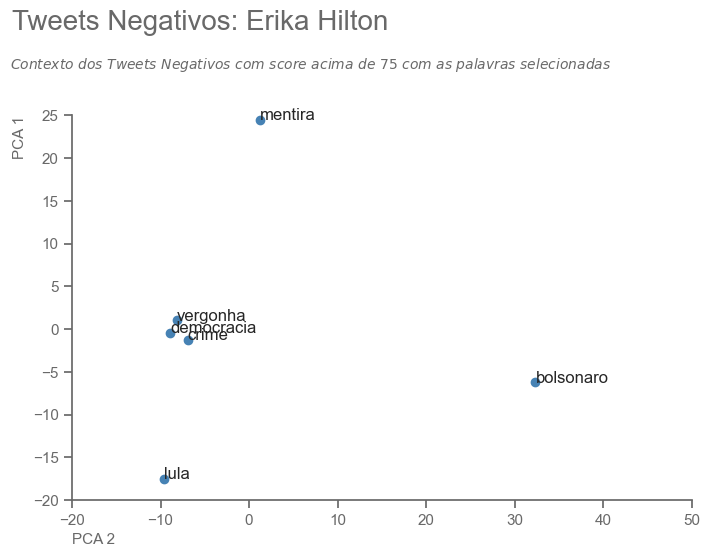

In [63]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca_neg_75:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets Negativos: Erika Hilton', fontsize=20, x=0.207, y=1.2, color="#696969")
ax.set_xlim(-20,50)
ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ dos\ Tweets\ Negativos\ com\ score\ acima\ de\ 75\ com\ as\ palavras\ selecionadas}$"

# Add the subtitle with formatted text
ax.text(0.385, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')

# Similaridade de vetores

In [64]:
# Visualizando vetores similares ao vetor "bolsonaro" modelo com tweets negativos acima de 75%
w2v_model_neg_75.wv.most_similar('bolsonaro')

[('mentiu', 0.9904772639274597),
 ('novamente', 0.9051870703697205),
 ('mente', 0.89958256483078),
 ('sonegadores', 0.8681256771087646),
 ('censurou', 0.8360270857810974),
 ('mexa', 0.8183808326721191),
 ('janones', 0.8084629774093628),
 ('salário', 0.744744062423706),
 ('inocente', 0.6594069004058838),
 ('mg', 0.656850278377533)]

In [66]:
# Visualizando vetores similares ao vetor "lula" modelo com tweets negativos acima de 75%
w2v_model_neg_75.wv.most_similar('lula')

[('criminoso', 0.9965492486953735),
 ('venceu', 0.9930444359779358),
 ('debate', 0.9912573099136353),
 ('macetando', 0.9905771017074585),
 ('mentiroso', 0.989382803440094),
 ('andrejanonesadv', 0.9873030781745911),
 ('aposentados', 0.9871935248374939),
 ('sonegação', 0.9871827363967896),
 ('live', 0.9869392514228821),
 ('peguem', 0.986737072467804)]

In [84]:
# Visualizando vetores similares ao vetor "erikakhilton" modelo com tweets negativos acima de 75%
w2v_model_neg_75.wv.most_similar('erikakhilton', topn = 30)

[('governador', 0.995364785194397),
 ('tarcísio', 0.9952459335327148),
 ('haddad_fernando', 0.9952071905136108),
 ('destruir', 0.9944586157798767),
 ('felipe', 0.9942419528961182),
 ('haddad', 0.9941981434822083),
 ('miliciano', 0.9936178922653198),
 ('corja', 0.9934934973716736),
 ('máquina', 0.9933931231498718),
 ('precisa', 0.9933472275733948),
 ('poste', 0.9933174848556519),
 ('homem', 0.9932505488395691),
 ('orçamento', 0.9931420087814331),
 ('prefeito', 0.9931219816207886),
 ('jair', 0.9931091070175171),
 ('nao', 0.993082582950592),
 ('conta', 0.9930473566055298),
 ('após', 0.9929585456848145),
 ('cenoura', 0.992947518825531),
 ('máfia', 0.9929078817367554),
 ('ladrão', 0.9928804039955139),
 ('dias', 0.9928750395774841),
 ('paraisópolis', 0.9928117394447327),
 ('vcs', 0.9927882552146912),
 ('estado', 0.9927820563316345),
 ('tirar', 0.9927747845649719),
 ('sp', 0.9927642345428467),
 ('aqui', 0.9927229881286621),
 ('maior', 0.992697536945343),
 ('ódio', 0.9926276803016663)]

In [68]:
def limpar_texto(texto):
    # Converte para caixa baixa
    texto = texto.lower()
    
    # Tokenização
    doc = nlp(texto)
    
    # Exclui STOPWORDS, pontuação e números
    tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and not token.like_num]
    
    # Agrupando review
    texto_limpo = " ".join(tokens)
    
    return texto_limpo


In [70]:
# Apply the cleaning function to the 'text_column' in the DataFrame
df_classif_erika_modelo_pos_ajuste['texto_limpo'] = df_classif_erika_modelo_pos_ajuste['tweets'].apply(limpar_texto)

In [71]:
# Apply the cleaning function to the 'text_column' in the DataFrame
tweets_neg_acima_75['texto_limpo'] = tweets_neg_acima_75['tweets'].apply(limpar_texto)

C:\Users\55199\AppData\Local\Temp\ipykernel_884\2431006854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_neg_acima_75['texto_limpo'] = tweets_neg_acima_75['tweets'].apply(limpar_texto)


In [72]:
def nome_colunas(tokenizer, data_frame):
    # Extrai rotulos dos tokens
    vocabulario = {v: k for k, v in tokenizer.vocabulary_.items()}
    
    # Atribui rotulos dos tokens as colunas apropriadas
    data_frame.columns = data_frame.columns.map(vocabulario)
    
    return data_frame

In [76]:
# Instanciando CountVectorizer
tokenizer_unigram = CountVectorizer(ngram_range=(1,1))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_unigram = tokenizer_unigram.fit_transform(df_classif_erika_modelo_pos_ajuste['tokens_texto'])

# Criação do DF
bow_unigram_df = pd.DataFrame(bow_unigram.todense())

# Verificando 50 termos mais frequentes
nome_colunas(tokenizer_unigram, bow_unigram_df)

,00,000,0000,001,005,00h,01,01ojhlzolg,02,021,...,𝗔𝗠𝗔𝗡𝗛𝗔,𝗟𝗨𝗟𝗔,𝗣𝗥𝗘𝗦𝗜𝗗𝗘𝗡𝗧𝗘,𝘾𝙤𝙢𝙚𝙣𝙩𝙖,𝙀𝙡𝙚𝙞𝙩𝙤𝙧𝙖𝙡,𝙋𝙚𝙡𝙤,𝙍𝙚𝙢𝙤𝙫𝙞𝙙𝙤,𝙎𝙪𝙥𝙚𝙧𝙞𝙤𝙧,𝙏𝙧𝙞𝙗𝙪𝙣𝙖𝙡,𝙧𝙞𝙤
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22500,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22502,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
# Unigrams para todos os tweets
bow_unigram_df.sum().sort_values(ascending=False).head(30)

erikakhilton       19086
https               3936
co                  3936
bolsonaro           2627
lula                2296
pra                 1468
paulo               1435
haddad_fernando     1333
lulaoficial         1187
vai                 1100
erika                933
mentiu               819
vota                 765
zambelli             728
presidente           711
assassino            695
13                   677
vc                   638
propostas            630
vote                 613
lulanoflow           573
região               554
haddad               543
tá                   526
tarcísio             504
sp                   488
debate               486
gente                476
vamos                473
voto                 471
dtype: int64

In [78]:
# Instanciando CountVectorizer
tokenizer_unigram_neg_75 = CountVectorizer(ngram_range=(1,1))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_unigram_neg_75 = tokenizer_unigram_neg_75.fit_transform(tweets_neg_acima_75['tokens_texto'])

# Criação do DF
bow_unigram_df_neg_75 = pd.DataFrame(bow_unigram_neg_75.todense())

# Verificando 50 termos mais frequentes
nome_colunas(tokenizer_unigram_neg_75, bow_unigram_df_neg_75)

,00,03,04,05,0digxfqlud,0vz28f62f9,0xp3fie9ic,10,100,10chk0owrg,...,área,época,érika,ódio,óleo,ônibus,ôrra,única,único,ķkkk
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
# Unigrams para tweets com score acima de 75%
bow_unigram_df_neg_75.sum().sort_values(ascending=False).head(30)

erikakhilton    1830
bolsonaro       1644
mentiu           731
paulo            636
vota             611
assassino        608
zambelli         238
lula             217
janones          178
sonegadores      173
https            168
co               168
carla            147
censurou         134
pra              115
vai              112
bolsolão         109
terrorista        99
inocente          96
live              96
mente             89
salário           86
mexa              80
asfalto           78
sonegação         78
10                75
lulaoficial       71
cadeia            70
tá                62
odeia             61
dtype: int64

# Avaliação de contexto entre todos tweets x tweets negativos acaba na celula acima

In [46]:
# Instanciando CountVectorizer
tokenizer_bigram = CountVectorizer(ngram_range = (2,2))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_bigram = tokenizer_bigram.fit_transform(tweets_neg_acima_75['tokens_texto'])

# Criação do DF
bow_bigram_df = pd.DataFrame(bow_bigram.todense())

# Aplicando função
nome_colunas(tokenizer_bigram, bow_bigram_df)

,00 ai,00 hs,03 abandonou,04 aborto,05 horas,10 10,10 22,10 anos,10 bolsonaro,10 cabeça,...,óleo peroba,ônibus lotado,ônibus normalmente,ônibus primeiro,ôrra meu,única coisa,única refeição,único coragem,único rótulo,ķkkk quem
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# Verificando 50 termos mais frequentes
bow_bigram_df.sum().sort_values(ascending=False).head(50)

bolsonaro mentiu                727
vota assassino                  599
paulo vota                      596
mentiu bolsonaro                505
assassino paulo                 406
erikakhilton bolsonaro          270
sonegadores bolsonaro           169
https co                        168
carla zambelli                  142
erikakhilton paulo              137
bolsonaro censurou              134
censurou janones                133
janones bolsonaro               100
lula inocente                    95
zambelli terrorista              88
mexa salário                     80
live sonegação                   78
bolsonaro mente                  77
bolsolão asfalto                 71
bolsonaro mexa                   71
bolsonaro sonegadores            69
salário bolsonaro                68
erikakhilton carla               68
10 10                            66
inocente lula                    61
bolsonaro odeia                  59
pistoleira bolsonaro             58
zambelli pistoleira         

In [48]:
# Instanciando CountVectorizer
tokenizer_trigram = CountVectorizer(ngram_range=(3,3))

# Fit e transform dos reviews limpos, cria uma matriz esparsa
bow_trigram = tokenizer_trigram.fit_transform(tweets_neg_acima_75['tokens_texto'])

# Criando DF
bow_trigram_df = pd.DataFrame(bow_trigram.todense())

# Aplicando função
nome_colunas(tokenizer_trigram, bow_trigram_df)

,00 ai voces,00 hs ponto,03 abandonou sp,04 aborto proibido,05 horas manhã,10 10 10,10 22 arroaceiros,10 anos acredita,10 anos subiu,10 bolsonaro 22,...,óleo peroba tá,ônibus lotado metrô,ônibus normalmente passa,ônibus primeiro turno,ôrra meu reage,única coisa sei,única refeição monstro,único coragem missão,único rótulo cabe,ķkkk quem lhe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# Verificando 50 termos mais frequentes
bow_trigram_df.sum().sort_values(ascending=False).head(50)

paulo vota assassino                  595
bolsonaro mentiu bolsonaro            505
mentiu bolsonaro mentiu               491
assassino paulo vota                  406
vota assassino paulo                  405
erikakhilton bolsonaro mentiu         173
erikakhilton paulo vota               136
bolsonaro censurou janones            133
censurou janones bolsonaro            100
janones bolsonaro censurou             95
carla zambelli terrorista              75
bolsonaro mexa salário                 71
bolsonaro sonegadores bolsonaro        69
sonegadores bolsonaro sonegadores      68
mexa salário bolsonaro                 67
10 10 10                               65
erikakhilton carla zambelli            64
lula inocente lula                     61
inocente lula inocente                 60
salário bolsonaro mexa                 59
zambelli pistoleira bolsonaro          58
bolsonaro mente bolsonaro              57
mente bolsonaro mente                  55
carla zambelli pistoleira         

In [50]:
# Definindo palavras que serão visualizadas
palavras = ['erikakhilton','bolsonaro','terrorista']

# palavras = ['lula','bolsonaro','vergonha','crime','mentira', 'democracia']

palavras1 = ['lula','bolsonaro','crime']

palavras2 = ['lula','bolsonaro','mentira']

palavras3 = ['lula','bolsonaro','democracia']

In [51]:
# Obtendo vetores das palavras
palavra_vec = []
for i in palavras:
    palavra_vec.append(w2v_model.wv.get_vector(i))

# Padronizando os dados (subtrai média e divide pelo desvio padrão)    
x = StandardScaler().fit_transform(palavra_vec)

# Instanciando PCA
pca = PCA(n_components=2)

# Fitando PCA
palavras_pca = pca.fit_transform(x)

Text(0.255, 1.12, '${Contexto\\ para\\ palavras\\ com\\ maior\\ similaridade\\ ao\\ nome\\ Erika}$')

<Figure size 800x500 with 0 Axes>

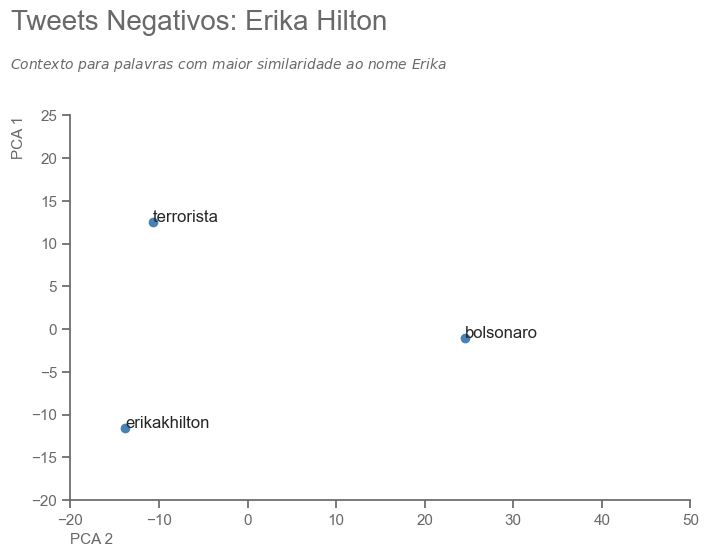

In [52]:
# Criando listas com valores do eixo x e y
eixo_x = []
eixo_y = []
for i in palavras_pca:
    eixo_x.append(i[0])
    eixo_y.append(i[1])

# Plotando resultado
plt.figure(figsize=(8, 5))
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(eixo_x, eixo_y, color = 'steelblue')
ax.set_title('Tweets Negativos: Erika Hilton', fontsize=20, x=0.207, y=1.2, color="#696969")
ax.set_xlim(-20,50)
ax.set_ylim(-20,25)
ax.spines['bottom'].set_color('#696969')  
ax.spines['left'].set_color('#696969')  
ax.tick_params(axis='x', colors='#696969')  
ax.tick_params(axis='y', colors='#696969')
ax.set_ylabel("PCA 1", fontsize=11, loc="top", color="#696969")
ax.set_xlabel("PCA 2", fontsize=11, loc="left", color="#696969")
for i, txt in enumerate(palavras):
    ax.annotate(txt, (eixo_x[i], eixo_y[i]))

subtitle_text = r"${Contexto\ para\ palavras\ com\ maior\ similaridade\ ao\ nome\ Erika}$"

# Add the subtitle with formatted text
ax.text(0.255, 1.12, subtitle_text, transform=ax.transAxes, fontsize=10, ha='center', color='#696969')